# ECBM E4040 - Assignment 1, Task 3: Dimensionality Reduction

This task is devoted to dimensionality reduction. How to map high-dimensional data into low-dimensional space is an interesting topic in the machine learning field. It is related to another hot topic -- unsupervised learning. In this section, you are going to learn two different methods for this dimensionality reduction.

* Principal Component Analysis (PCA)
* t-Distributed Stochastic Neighbor Embedding (t-SNE) 

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from ecbm4040.cifar_utils import load_data

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

We will use the CIFAR-10 dataset.

In [2]:
# Load the raw CIFAR-10 data.
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape([50000,3,32,32]).transpose((0,2,3,1))
X_test = X_test.reshape([10000,3,32,32]).transpose((0,2,3,1))
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# Data organizations:
# Train data: 49000 samples from original train set: 1~49000
# Validation data: 1000 samples from original train set: 49000~50000
# Test data: 10000 samples from original test set: 1~10000
# Development data (for gradient check): 100 from the train set: 1~49000 #TODOTA is this 100 or 1000?
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
(49000, 32, 32, 3) (1000, 32, 32, 3) (10000, 32, 32, 3) (100, 32, 32, 3)
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Development data shape: (100, 32, 32, 3)
Development data shape (100,)


## Part 1: Principal Component Analysis (PCA)

### Naive PCA

In [3]:
from ecbm4040.features.pca import pca_naive

X_patch = X_train[:,:,:,0]
X_patch = np.reshape(X_patch, (X_patch.shape[0], -1))

In [4]:
# Start PCA
K = 500
P, T = pca_naive(X_patch, K)

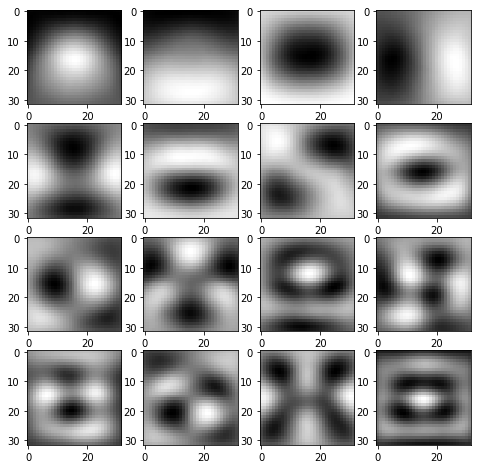

In [5]:
# Show principle components of P using a 4x4 subplot
# Visualize P
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = np.reshape(P[r*i+j], [32,32])
        axarr[i][j].imshow(img, cmap="gray")

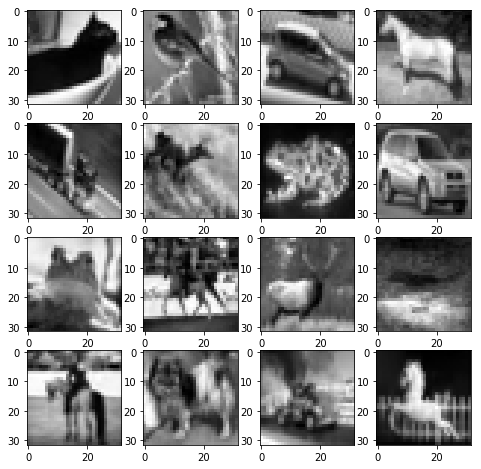

In [6]:
# Select a small set of images for test
num_training = 50000
num_pca = 16
mask = np.random.choice(num_training, num_pca, replace=False)
X_pca = X_train[mask,:,:,0]

# Visualize one channel of images 
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_pca[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

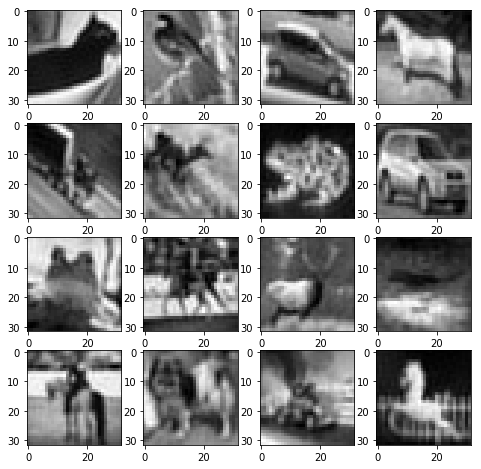

In [7]:
# Test your result
# Reduce dimension with P
X_features = []
for n in range(num_pca):
    img = X_pca[n]
    feature = np.dot(P, np.reshape(img, (-1,)))
    X_features.append(feature)

# Reconstruct image
X_recon = []
for n in range(num_pca):
    feature = X_features[n]
    img = np.reshape(np.dot(feature, P), (32,32))
    X_recon.append(img)

# Visualize results
r = 4
f, axarr = plt.subplots(r, r, figsize=(8,8))
for i in range(r):
    for j in range(r):
        img = X_recon[r*i+j]
        axarr[i][j].imshow(img, cmap="gray")

### PCA + Neural network

In [8]:
from ecbm4040.train_funcs import train, test
from ecbm4040.classifiers.mlp import MLP

# pca preprocessing -> mlp classification
# X-train  processing
X_train1 = X_train[:,:,:,0]
X_train1 = X_train1.flatten().reshape(49000, 1024)

X_train2 = X_train[:,:,:,1]
X_train2 = X_train2.flatten().reshape(49000, 1024)

X_train3 = X_train[:,:,:,2]
X_train3 = X_train3.flatten().reshape(49000, 1024)

P_train1, T_train1 = pca_naive(X_train1, K)
P_train2, T_train2 = pca_naive(X_train2, K)
P_train3, T_train3 = pca_naive(X_train3, K)

X_train1_reduced = np.dot(X_train1, P_train1.T)
X_train2_reduced = np.dot(X_train2, P_train2.T)
X_train3_reduced = np.dot(X_train3, P_train3.T)
X_train_processed = np.column_stack((X_train1_reduced, X_train2_reduced, X_train3_reduced))

# X-val  processing
X_val1 = X_val[:,:,:,0]
X_val1 = X_val1.flatten().reshape(1000, 1024)

X_val2 = X_val[:,:,:,1]
X_val2 = X_val2.flatten().reshape(1000, 1024)

X_val3 = X_val[:,:,:,2]
X_val3 = X_val3.flatten().reshape(1000, 1024)

P_val1, T_val1 = pca_naive(X_val1, K)
P_val2, T_val2 = pca_naive(X_val2, K)
P_val3, T_val3 = pca_naive(X_val3, K)

X_val1_reduced = np.dot(X_val1, P_val1.T)
X_val2_reduced = np.dot(X_val2, P_val2.T)
X_val3_reduced = np.dot(X_val3, P_val3.T)
X_val_processed = np.column_stack((X_val1_reduced, X_val2_reduced, X_val3_reduced))

# X-dev  processing
X_dev1 = X_dev[:,:,:,0]
X_dev1 = X_dev1.flatten().reshape(100, 1024)

X_dev2 = X_dev[:,:,:,1]
X_dev2 = X_dev2.flatten().reshape(100, 1024)

X_dev3 = X_dev[:,:,:,2]
X_dev3 = X_dev3.flatten().reshape(100, 1024)

P_dev1, T_dev1 = pca_naive(X_dev1, K)
P_dev2, T_dev2 = pca_naive(X_dev2, K)
P_dev3, T_dev3 = pca_naive(X_dev3, K)

X_dev1_reduced = np.dot(X_dev1, P_dev1.T)
X_dev2_reduced = np.dot(X_dev2, P_dev2.T)
X_dev3_reduced = np.dot(X_dev3, P_dev3.T)
X_dev_processed = np.column_stack((X_dev1_reduced, X_dev2_reduced, X_dev3_reduced))

# X-test  processing
X_test1 = X_test[:,:,:,0]
X_test1 = X_test1.flatten().reshape(10000, 1024)

X_test2 = X_test[:,:,:,1]
X_test2 = X_test2.flatten().reshape(10000, 1024)

X_test3 = X_test[:,:,:,2]
X_test3 = X_test3.flatten().reshape(10000, 1024)

P_test1, T_test1 = pca_naive(X_test1, K)
P_test2, T_test2 = pca_naive(X_test2, K)
P_test3, T_test3 = pca_naive(X_test3, K)

X_test1_reduced = np.dot(X_test1, P_test1.T)
X_test2_reduced = np.dot(X_test2, P_test2.T)
X_test3_reduced = np.dot(X_test3, P_test3.T)
X_test_processed = np.column_stack((X_test1_reduced, X_test2_reduced, X_test3_reduced))


model = MLP(input_dim=1500, hidden_dims=[100, 100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 500
lr = 1e-2
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train_processed, y_train, X_val_processed, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test_acc_hist = test(model, X_test_processed, y_test)

number of batches for training: 98
epoch 1: valid acc = 0.102, new learning rate = 0.0095
epoch 2: valid acc = 0.078, new learning rate = 0.009025
epoch 3: valid acc = 0.102, new learning rate = 0.00857375
epoch 4: valid acc = 0.083, new learning rate = 0.0081450625
epoch 5: valid acc = 0.097, new learning rate = 0.007737809374999999
epoch 6: valid acc = 0.09, new learning rate = 0.007350918906249998
epoch 7: valid acc = 0.086, new learning rate = 0.006983372960937498
epoch 8: valid acc = 0.041, new learning rate = 0.006634204312890623
epoch 9: valid acc = 0.035, new learning rate = 0.006302494097246091
epoch 10: valid acc = 0.049, new learning rate = 0.005987369392383786
test acc: 0.2824


Training, validation and test set accuracy.

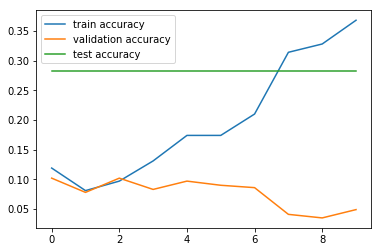

In [9]:
test_acc_hist = [test_acc_hist] * 10

plt.plot(train_acc_hist, label="train accuracy")
plt.plot(val_acc_hist, label="validation accuracy")
plt.plot(test_acc_hist, label="test accuracy")
plt.legend()
plt.show()

## Part 2: t-SNE

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR10. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [10]:
from ecbm4040.features.tsne import tsne

#### tSNE of original data

In [11]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test[random_select,:,:,0].reshape(500,1024).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

C:\Users\Alokik\Dropbox\Working\Github\DeepLearning\Assignment1\ecbm4040\features\tsne.py:9: RuntimeWarning: divide by zero encountered in log
  H = -np.dot(np.log(P), P)


2.503123869996932
The 100 th loop cost: 14.45271953867886, computation time: 2.3449106216430664
The 200 th loop cost: 1.1127157169903694, computation time: 4.595425128936768
The 300 th loop cost: 1.109292181163056, computation time: 6.881466865539551
The 400 th loop cost: 1.109265750366925, computation time: 9.187442779541016
The 500 th loop cost: 1.1092657286826897, computation time: 11.480105876922607
The 600 th loop cost: 1.1092657286640981, computation time: 13.949028730392456
The 700 th loop cost: 1.1092657286640693, computation time: 16.244406938552856
The 800 th loop cost: 1.109265728664069, computation time: 18.521364450454712
The 900 th loop cost: 1.1092657286640688, computation time: 20.815629243850708
The 1000 th loop cost: 1.1092657286640693, computation time: 23.08844542503357
it takes 23.794378757476807 seconds


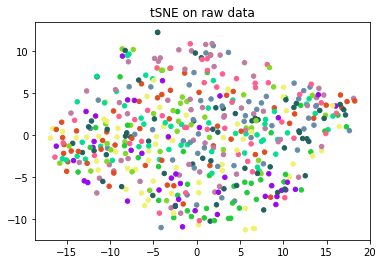

In [12]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.title("tSNE on raw data")
plt.savefig("images/tSNE1.png")
plt.show()

#### tSNE of data after two hidden layers

In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, the tSNE of data after two-layer networks is shown as multiple clusters in a 2D panel.

In [13]:
# Define MLP model
X_train = X_train.reshape(49000, 3072)
X_test = X_test.reshape(10000, 3072)
X_val = X_val.reshape(1000, 3072)
X_dev = X_dev.reshape(100, 3072)
model = MLP(input_dim=3072, hidden_dims=[100], num_classes=10, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.427, new learning rate = 0.00095
epoch 2: valid acc = 0.463, new learning rate = 0.0009025
epoch 3: valid acc = 0.476, new learning rate = 0.000857375
epoch 4: valid acc = 0.481, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.481, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.501, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.508, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.523, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.512, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.499, new learning rate = 0.0005987369392383785
test acc: 0.5019


0.5019

In [15]:
# run tSNE
X = X_test[random_select]
X = model.layers[0].feedforward(X)
X = model.layers[1].feedforward(X)
X_exp = np.exp(X)
X = X_exp / np.tile(np.sum(X_exp, axis=1, keepdims=True), 10)

tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

0.19412249860000858
The 100 th loop cost: 11.207509495880803, computation time: 2.3145699501037598
The 200 th loop cost: 0.5193400049867024, computation time: 4.7041778564453125
The 300 th loop cost: 0.5007639131038891, computation time: 7.02108359336853
The 400 th loop cost: 0.4962105427109076, computation time: 9.378886699676514
The 500 th loop cost: 0.49455250592977, computation time: 11.676204442977905
The 600 th loop cost: 0.4942977163662437, computation time: 14.050289630889893
The 700 th loop cost: 0.4942260072519818, computation time: 16.40701651573181
The 800 th loop cost: 0.49420193654597694, computation time: 18.69267749786377
The 900 th loop cost: 0.4941927568842904, computation time: 20.99481511116028
The 1000 th loop cost: 0.49418907402725837, computation time: 23.304503679275513
it takes 24.0696017742157 seconds


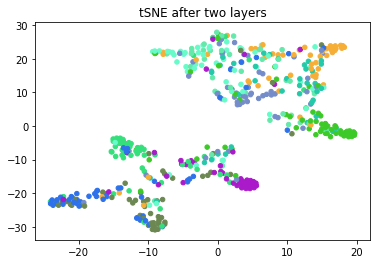

In [19]:
# visualize tSNE 2D representation of data after two hidden layers
labels = y_test[random_select]
colors = np.random.rand(10,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.title("tSNE after two layers")
plt.savefig("images/tSNE2.png")
plt.show()